In [1]:
from utils import show_task_activation, plot_fmap
from utils import process_gray_matter_mask, create_4d_volume, create_events_df, compute_task_fmap, compute_bins_threshold
from utils import subject_gm_mask_path, paradigm_dir, subject_task_active_mask_path, subject_task_regressor_path, subject_task_sample_prefix
from utils import mkdir_no_exist, x_coords, y_coords, z_coords
# from viz import plot_voxel_timecourse

import os
from os.path import join as pjoin
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from glob import glob

import nibabel as nib
from nilearn import image
from nilearn.glm import threshold_stats_img
from nilearn.glm.first_level import FirstLevelModel, run_glm
from nilearn.plotting import (
    plot_design_matrix,
    plot_stat_map,
    plot_img,
    plot_glass_brain,
)

In [2]:
HCP_dir = '/media/miplab-nas2/HCP-Data'
paradigm_dir = pjoin(HCP_dir,'HCP_100unrelated_TaskParadigms')
fMRI_dir = pjoin(HCP_dir,'HCP_100unrelated_preprocessed_ERG/data')

project_dir = '/media/RCPNAS/Data2/CS-433-ML4S/'
project_data_dir = pjoin(project_dir, 'data')
project_dataset_dir = pjoin(project_dir, "dataset")

derivatives_dir = pjoin(project_data_dir, 'derivatives')

anat_dir = pjoin(derivatives_dir, 'anat')
func_dir = pjoin(derivatives_dir, 'func')
events_dir = pjoin(project_data_dir, 'events')

mkdir_no_exist(anat_dir)
mkdir_no_exist(func_dir)
mkdir_no_exist(events_dir)
mkdir_no_exist(project_dataset_dir)

In [3]:
subject = "127630"
task = "MOTOR"
acq = "RL"
smoothing = 10
TR = 0.72 

In [4]:
def subject_run(sid, acquisition):
    return {"id": sid, "acquisition": acquisition}

In [123]:
def plot_voxel_timecourse(predicted_voxel, binary_design_matrix):
    plt.figure(figsize=(20, 5))

    n_voxels = predicted_voxel.shape[0]
    max_h = 0.0
    for i in range(n_voxels):
        max_h = max(max_h, np.max(predicted_voxel[i,:]))
        plt.plot(predicted_voxel[i,:], alpha=0.6)
    
    
    df = binary_design_matrix
    for col in df.columns:
        plt.fill_between(range(len(df)), df[col] * max_h, label=col, alpha=0.1)

    plt.title('Individual Voxel Timecourses')
    plt.xticks(np.linspace(0, predicted_voxel.shape[1], num=10))
    plt.xlabel('Time')
    plt.ylabel('Signal')
    plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=len(df.columns)//2)
    plt.show()

In [110]:
def binary_design_matrix(events_df, TR, n_volumes):
    time_points = np.arange(0, n_volumes * TR, TR)
    conditions = sorted(events_df['trial_type'].unique())
    design_matrix = pd.DataFrame(0, index=time_points, columns=conditions)
    
    for _, event in events_df.iterrows():
        start_idx = np.searchsorted(time_points, event['onset'])
        end_idx = np.searchsorted(time_points, event['onset'] + event['duration'])
        design_matrix.iloc[start_idx:end_idx, conditions.index(event['trial_type'])] = 1
    
    return design_matrix

In [80]:
def voxel_activation_glm(brain_mask, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=brain_mask,
        t_r=TR,
        noise_model='ar1',
        standardize=False,
        hrf_model='spm',
        drift_model=None,
        minimize_memory=False,
    )

    return fmri_glm.fit(fmri_vols, events) 

In [8]:
def raw_voxel_activity_glm(mask_img, TR, fmri_vols, events):
    fmri_glm = FirstLevelModel(
        mask_img=mask_img,
        t_r=TR,
        noise_model='ar1', # or ols 
        standardize=False,
        hrf_model=None,
        drift_model=None, # not necessary, nuisance covariates have already been removed
        minimize_memory=False,
    )

    print(f"fitting GLM for task {task}")
    fitted_glm = fmri_glm.fit(fmri_vols, events)
    return fitted_glm

In [9]:
def create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_quantile, base_gm_mask_img, fmap_img, threshold):
    task_active_thr_map = subject_task_active_mask_path(subject, task, acquisition, smoothing, voxel_quantile)
    if os.path.isfile(task_active_thr_map):
        return nib.load(task_active_thr_map)

    gm_mask_data = base_gm_mask_img.get_fdata()
    fmap_data = fmap_img.get_fdata()

    threshold_mask = (fmap_data > threshold)

    active_data = fmap_data
    active_data[~threshold_mask] = 0
    active_data[threshold_mask] = 1

    active_img = nib.Nifti1Image(active_data, affine=base_gm_mask_img.affine, header=base_gm_mask_img.header)
    active_img.to_filename(task_active_thr_map)

    return active_img

In [10]:
def create_labeled_sample(save_prefix, bold_data, predicted_data, active_mask):
    voxel_coords = np.array(np.where((active_mask > 0))).T
    np.save(f'{save_prefix}voxel_mapping.npy', voxel_coords)

    X_list, Y_list = bold_data[active_mask > 0], predicted_data[active_mask > 0]
    for i, (X, Y) in enumerate(zip(X_list, Y_list)):
        np.save(f'{save_prefix}X_{i:04d}.npy', X)
        np.save(f'{save_prefix}Y_{i:04d}.npy', Y)

## label extraction strategies

The measured BOLD signal can be decomposed into:
\begin{aligned}
y(t) &= (x(t) \otimes h(t)) + \varepsilon(t) \\
x(t) &= \sum_{i=1}^{n} \beta_i s_i(t)
\end{aligned}

so

\begin{aligned}
y(t) &= \left(\sum_{i=1}^{n} \beta_i s_i(t) \otimes h(t) \right) + \varepsilon(t)
\end{aligned}

Where:

- dimensions: $T$ timepoints, $C$ conditions, $V$ voxels
- $y(t)$ is the measured BOLD signal (what we get from fMRI)
- $x(t)$ is the underlying neural activity - dim $(V, T)$
- $h(t)$ is the Hemodynamic Response Function (HRF)
- $\varepsilon(t)$ is measurement noise - dim $(V, T)$
- $\beta_i$ is the response amplitude for condition i - dim $(V, C)$
- $s_i(t)$ is the binary stimulus function (0/1) for condition i $s_i \in S$ - dim $(T, C)$
- $\otimes$ represents convolution
- $n$ is the number of conditions

In matrix notation:
\begin{aligned}
\mathbf{Y} &= \left(\mathbf{S}\boldsymbol{\beta}\right) \otimes \mathbf{h} + \boldsymbol{\varepsilon} \
\text{where } \mathbf{Y} &\in \mathbb{R}^{t}, \mathbf{S} \in \mathbb{R}^{t \times n}, \boldsymbol{\beta} \in \mathbb{R}^{n}
\end{aligned}

`get_predicted_bold_response` is then $(V, T)$
\begin{aligned}
\sum_{i=1}^{n} \beta_i s_i(t) \otimes h(t)
\end{aligned}

`get_predicted_neural_activity` is then $(V, T)$
\begin{aligned}
\sum_{i=1}^{n} \beta_i s_i(t)
\end{aligned}

`get_predicted_neural_activity_per_condition` such that (C, V, T)
\begin{aligned}
\boldsymbol{\beta} \times S
\end{aligned}

In [148]:
def get_predicted_bold_response(glm, active_mask_data, binary_design_matrix):    
    predicted = glm.predicted[0]
    predicted_data = predicted.get_fdata()[active_mask_data > 0]
    print(predicted_data.shape)

    plot_voxel_timecourse(predicted_data, binary_design_matrix)

    return predicted_data

def get_predicted_neural_activity(glm, active_mask_data, binary_design_matrix):
    n_volumes, n_regressors = glm.design_matrices_[0].shape
    n_conditions = n_regressors - 1 # drop constant regressor
    contrast_matrix = np.eye(n_conditions, n_regressors)

    # actual response (amplitude) in the voxel for each of the n_conditions
    betas_data = glm.compute_contrast(contrast_matrix, output_type='effect_size').get_fdata()
    active_voxel_beta = betas_data[active_mask_data > 0].reshape(-1, n_conditions)

    predicted_neural_activity =  active_voxel_beta @ binary_design_matrix.T.to_numpy()

    print(predicted_neural_activity.shape)
    plot_voxel_timecourse(predicted_neural_activity, binary_design_matrix)
    
    return predicted_neural_activity

def get_predicted_neural_activity_per_condition(glm, active_mask_data, binary_design_matrix):
    print(binary_design_matrix.shape)
    
    n_volumes, n_regressors = glm.design_matrices_[0].shape
    n_conditions = n_regressors - 1 # drop constant regressor
    contrast_matrix = np.eye(n_conditions, n_regressors)
    
    betas = activity_glm.compute_contrast(contrast_matrix, output_type='effect_size')
    betas_data = betas.get_fdata()
    active_voxel_beta = betas_data[active_mask_data > 0].reshape(-1, n_conditions)
    
    # binary_design: (T × C) = (284 × 10)
    # betas: (V × C) = (1937 × 10)
    # out output: (C × T × V) = (10 × 284 × 1937) beta for each condition for each ts for each voxel_activiy
    
    predictions = np.zeros((
        n_conditions,       # C = 10
        active_voxel_beta.shape[0],   # V = 1937
        n_volumes,       # T = 284
    ))

    binary_design_matrix = binary_design_matrix.to_numpy()
    for c in range(n_conditions):
        # binary_design[:, c] is (T,)
        # betas[:, c] is (V,)
        # outer product to get (T × V) for this condition
        # basically I want to be able to separate betas across condition (skip '@' = Sum_i beta_i cond_i)
        predictions[c] = np.outer(active_voxel_beta[:, c], binary_design_matrix[:, c])
    
    return predictions

In [115]:
def prepare_subject_sample(subject, task, acquisition, smoothing, voxel_quantile=98, label_extraction=get_predicted_neural_activity):
    gm_mask = subject_gm_mask_path(subject)
    print("processing subject gray matter mask", gm_mask)
    process_gray_matter_mask(anat_dir, subject, border_size=2, save=True, plot=False)

    print(f"concatenating volumes for task {task}")
    fmri_vols = create_4d_volume(subject, task, acquisition, smoothing, save=True)

    print("processing event conditions")
    events = create_events_df(subject, task, acquisition)

    regressors = scipy.io.loadmat(subject_task_regressor_path(subject, task, acquisition))
    regressors_ts = regressors['Regressor'].flatten()
    bdesign_matrix = binary_design_matrix(events, TR, fmri_vols.shape[-1])

    print("first GLM to select active voxel")
    activity_glm = voxel_activation_glm(gm_mask, TR, fmri_vols, events)
    
    n_regressors = activity_glm.design_matrices_[0].shape[1]
    n_conditions = n_regressors - 1 # drop constant regressor

    print(f"computing f-map and selecting {voxel_quantile}th voxel")
    contrast_matrix = np.eye(n_conditions, n_regressors)
    
    fmap = compute_task_fmap(subject, task, acquisition, smoothing, activity_glm, contrast_matrix)
    threshold = compute_bins_threshold(fmap, n_perc=voxel_quantile, show=False)

    # plot_fmap(fmap, threshold, display_mode="x", task=task, info={"subj": subject}, cut_cords=x_coords)
    # plot_fmap(fmap, threshold, display_mode="y", task=task, info={"subj": subject}, cut_cords=y_coords)
    # plot_fmap(fmap, threshold, display_mode="z", task=task, info={"subj": subject}, cut_cords=z_coords)

    gm_mask = nib.load(gm_mask)
    active_mask = create_active_voxel_mask(subject, task, acquisition, smoothing, voxel_activation_glm, gm_mask, fmap, threshold)
    active_mask_data = active_mask.get_fdata()

    return label_extraction(activity_glm, active_mask_data, bdesign_matrix)

In [116]:
subjetcs = [subject_run("127630", "RL")]

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
first GLM to select active voxel
computing f-map and selecting 98th voxel
n_volumes 284
n_regressors 11
n_conditions 10
contrast_matrix (10, 11)
binary_design (284, 10)
(1939, 284)


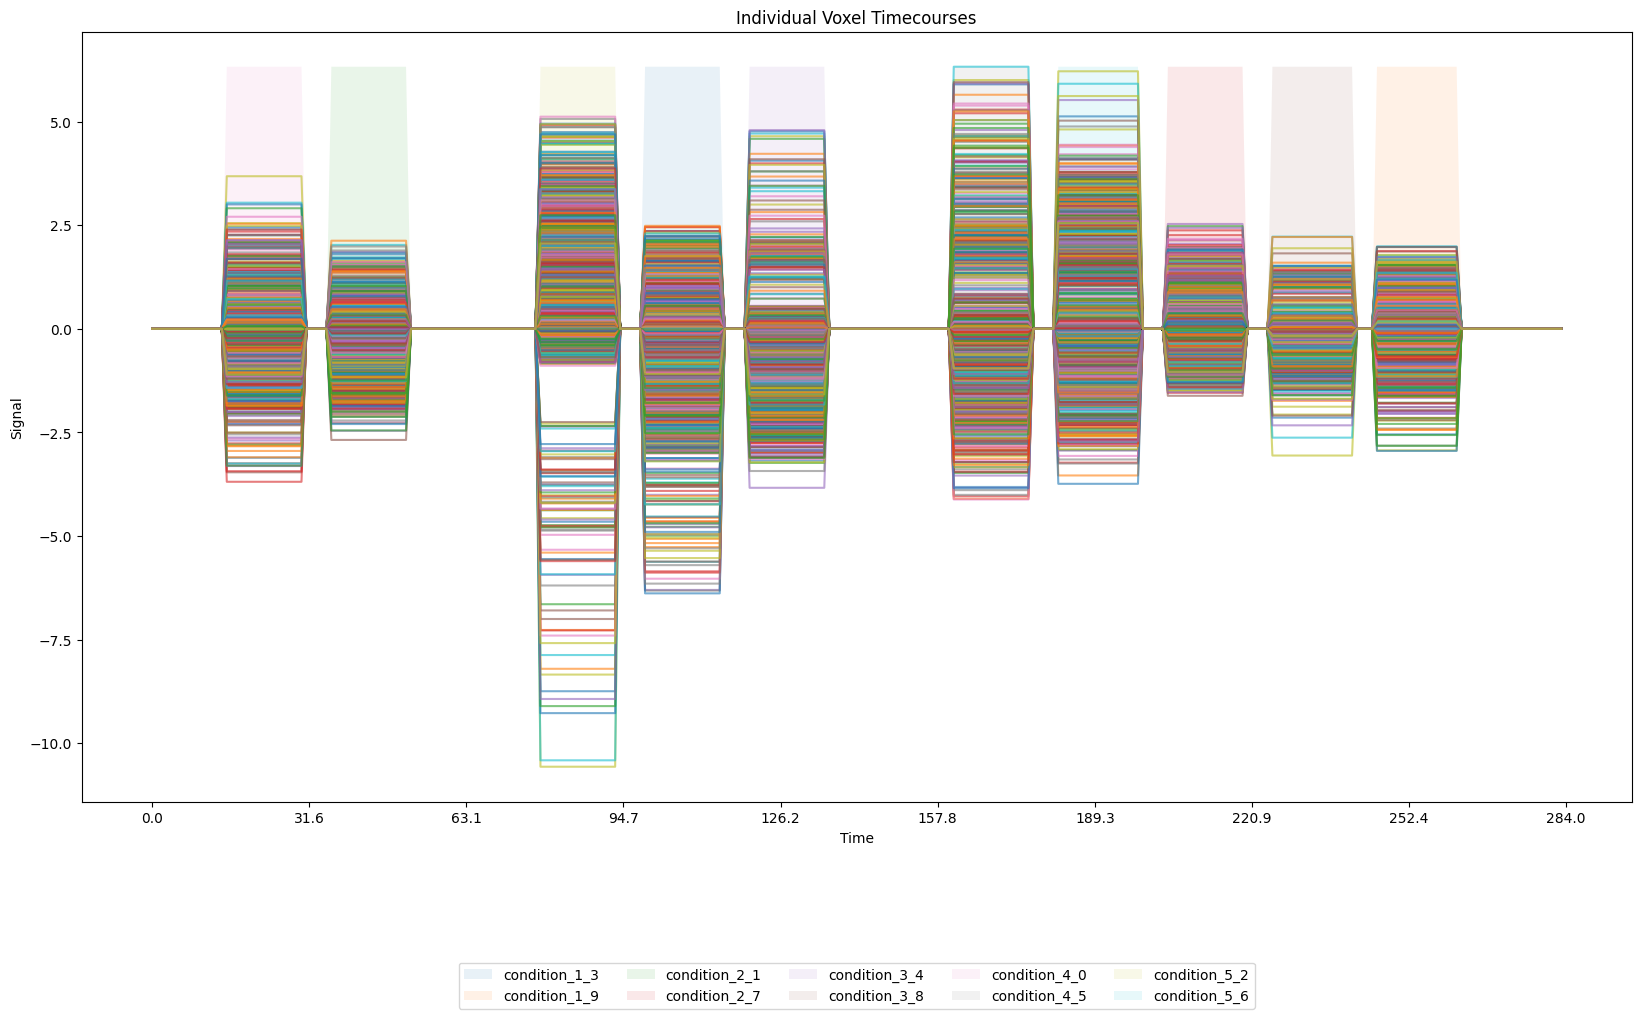

In [120]:
na = prepare_subject_sample(subject, task, acq, smoothing=10, label_extraction=get_predicted_neural_activity)

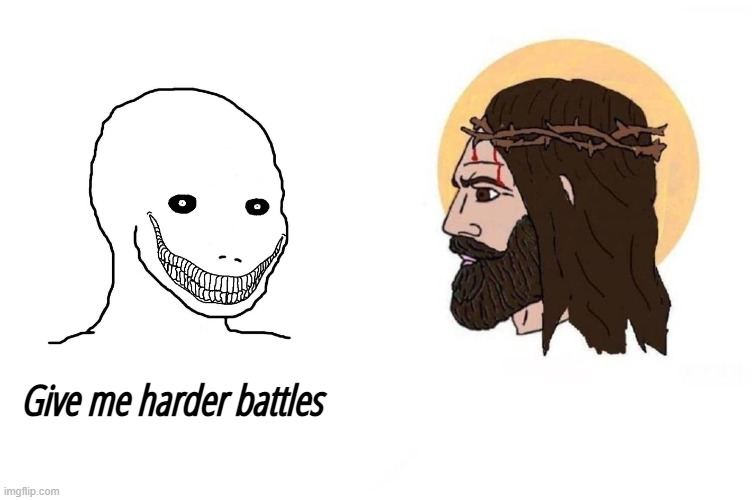;

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/127630_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz
files 127630_MOTOR_RL_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv
first GLM to select active voxel
computing f-map and selecting 98th voxel
(1939, 284)


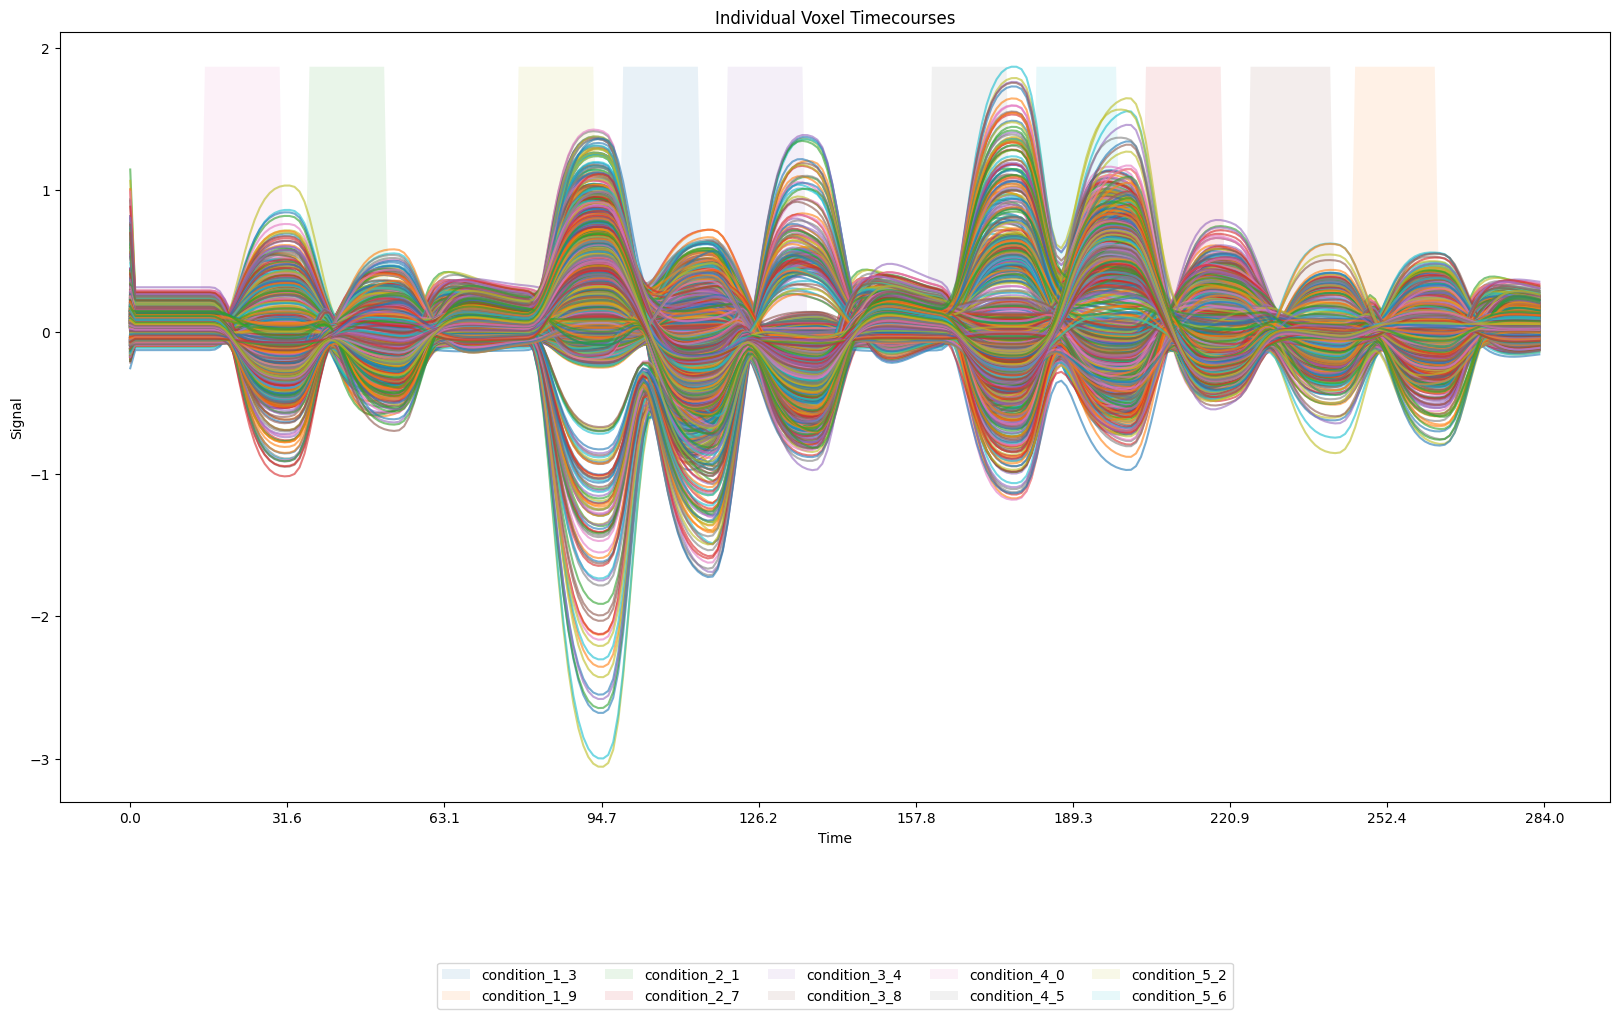

In [121]:
ba = prepare_subject_sample(subject, task, acq, smoothing=10, label_extraction=get_predicted_bold_response);

/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/127630_Regressor_tfMRI_MOTOR_RL.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/127630_MOTOR_RL_event.csv


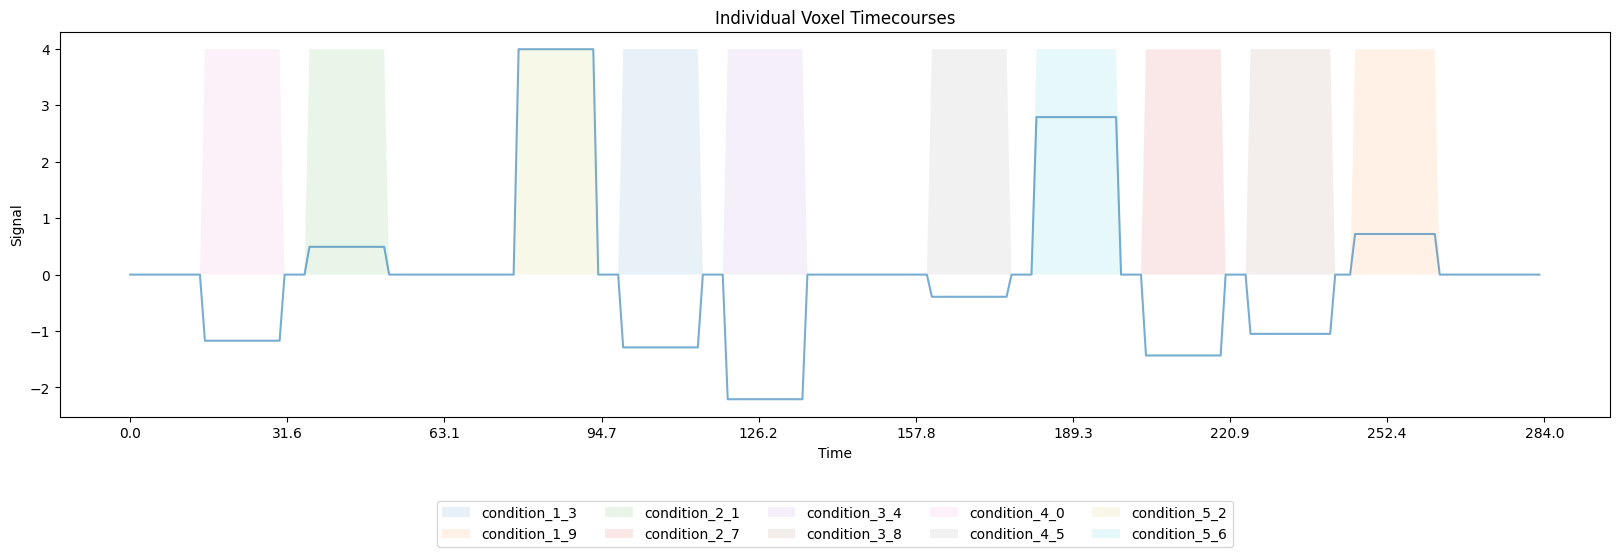

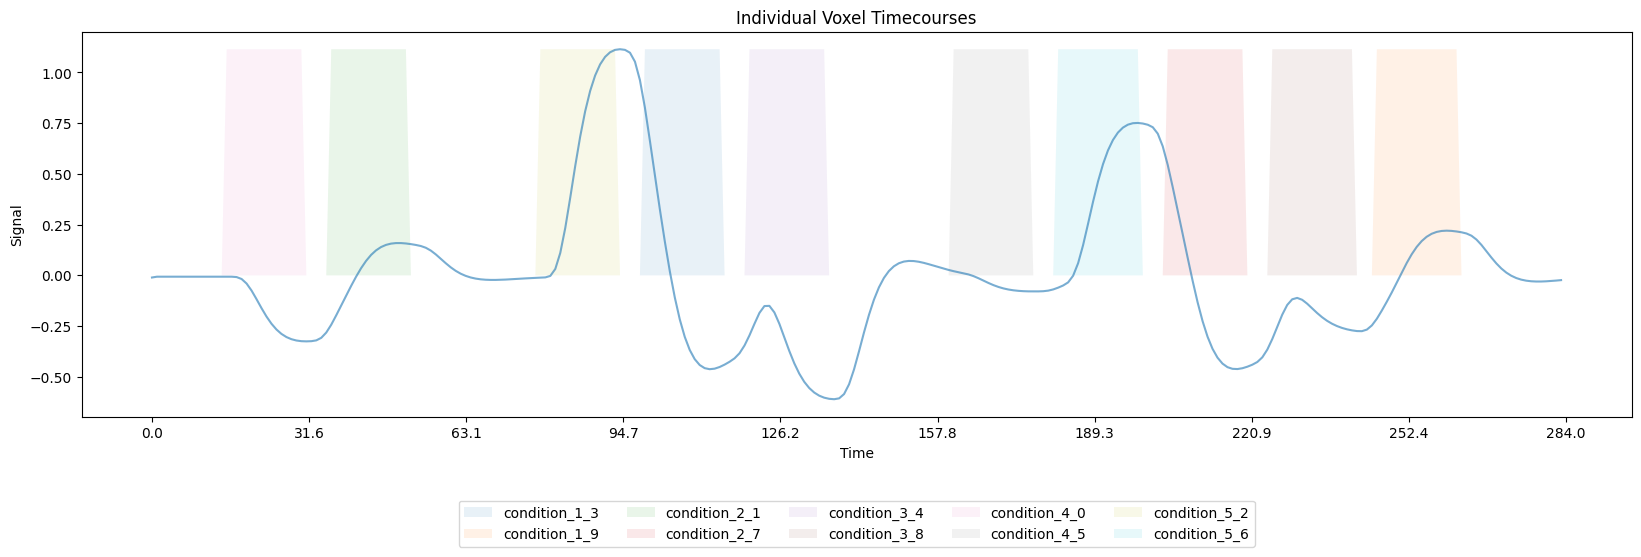

In [124]:
events = create_events_df(subject, task, acquisition)
bmatrix = binary_design_matrix(events, TR, fmri_vols.shape[-1])

voxels = [31]
plot_voxel_timecourse(na[voxels], bmatrix)
plot_voxel_timecourse(ba[voxels], bmatrix)

# testing other label extraction strategies

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz
files 113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_LR_event.csv
first GLM to select active voxel
computing f-map and selecting 98th voxel
(1930, 284)


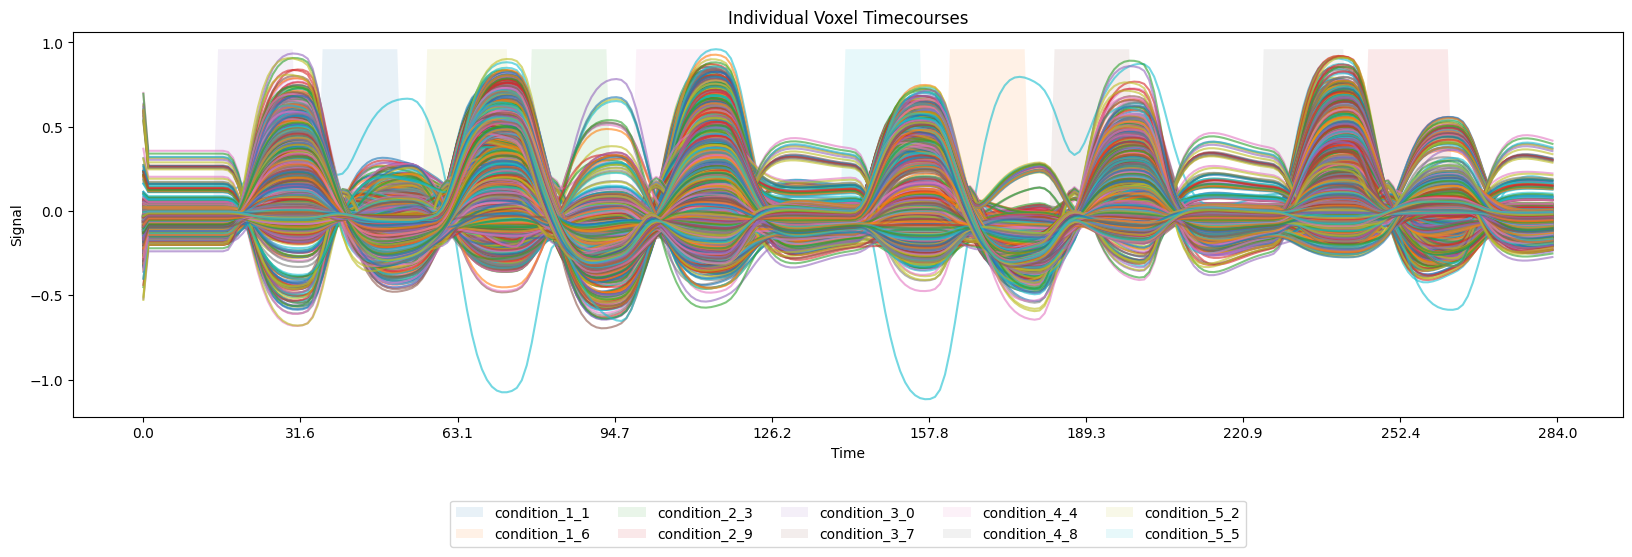

In [125]:
prepare_subject_sample("113619", task, "LR", smoothing=10, label_extraction=get_predicted_bold_response);

In [51]:
regressors = scipy.io.loadmat(subject_task_regressor_path("113619", task, "LR"))
flat_regressors = regressors['Regressor'].flatten()

In [149]:
activity_per_condition = prepare_subject_sample("113619", task, "LR", smoothing=10, label_extraction=get_predicted_neural_activity_per_condition)

processing subject gray matter mask /media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/anat/113619_gm_mask.nii.gz
concatenating volumes for task MOTOR
/media/RCPNAS/Data2/CS-433-ML4S/data/derivatives/func/113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz
files 113619_MOTOR_LR_smooth-10mm_fMRIvols.nii.gz already exists, skipping processing
processing event conditions
/media/miplab-nas2/HCP-Data/HCP_100unrelated_TaskParadigms/113619_Regressor_tfMRI_MOTOR_LR.mat
/media/RCPNAS/Data2/CS-433-ML4S/data/events/113619_MOTOR_LR_event.csv
first GLM to select active voxel
computing f-map and selecting 98th voxel
(284, 10)


In [17]:
sample_prefix = subject_task_sample_prefix("113619", "MOTOR", "LR", 10, 98)
print(sample_prefix)

def load_and_reconstruct_volume(prefix, vol_shape=(91, 109, 91)):
    X_files = sorted(glob(f"{prefix}X_*.npy"))
    Y_files = sorted(glob(f"{prefix}Y_*.npy"))
    
    # Load first file to get timepoints dimension
    first_X = np.load(X_files[0])
    n_timepoints = first_X.shape[0]
    
    flat_X = np.vstack([np.load(f) for f in X_files])
    flat_Y = np.vstack([np.load(f) for f in Y_files])
    
    mask = np.zeros(vol_shape)
    voxel_coords = np.where(mask.flatten() != 0)
    
    X_vol = np.zeros((*vol_shape, n_timepoints))
    Y_vol = np.zeros((*vol_shape, n_timepoints))
    
    X_vol.reshape(-1, n_timepoints)[voxel_coords] = flat_X
    Y_vol.reshape(-1, n_timepoints)[voxel_coords] = flat_Y
    
    return X_vol, Y_vol

/media/RCPNAS/Data2/CS-433-ML4S/dataset/113619_MOTOR_LR_smooth-10mm_98_


In [18]:
# X_vol, Y_vol = load_and_reconstruct_volume(sample_prefix)

In [21]:
# X_loaded

In [22]:
x = np.load('/media/RCPNAS/Data2/CS-433-ML4S/dataset/113619_MOTOR_LR_smooth-10mm_98_X_0949.npy')

In [23]:
x.shape

(284,)

In [143]:
activity_per_condition.shape

(10, 1930, 284)

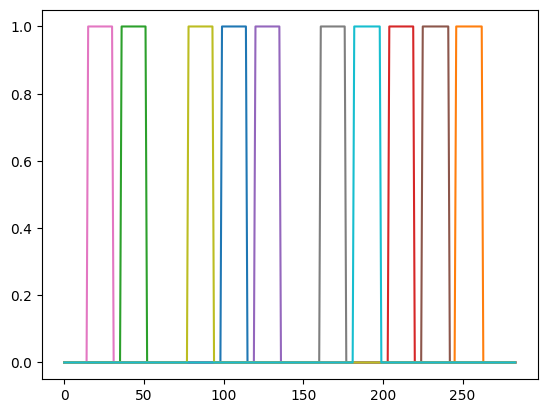

In [157]:
plt.plot(bmatrix.to_numpy());

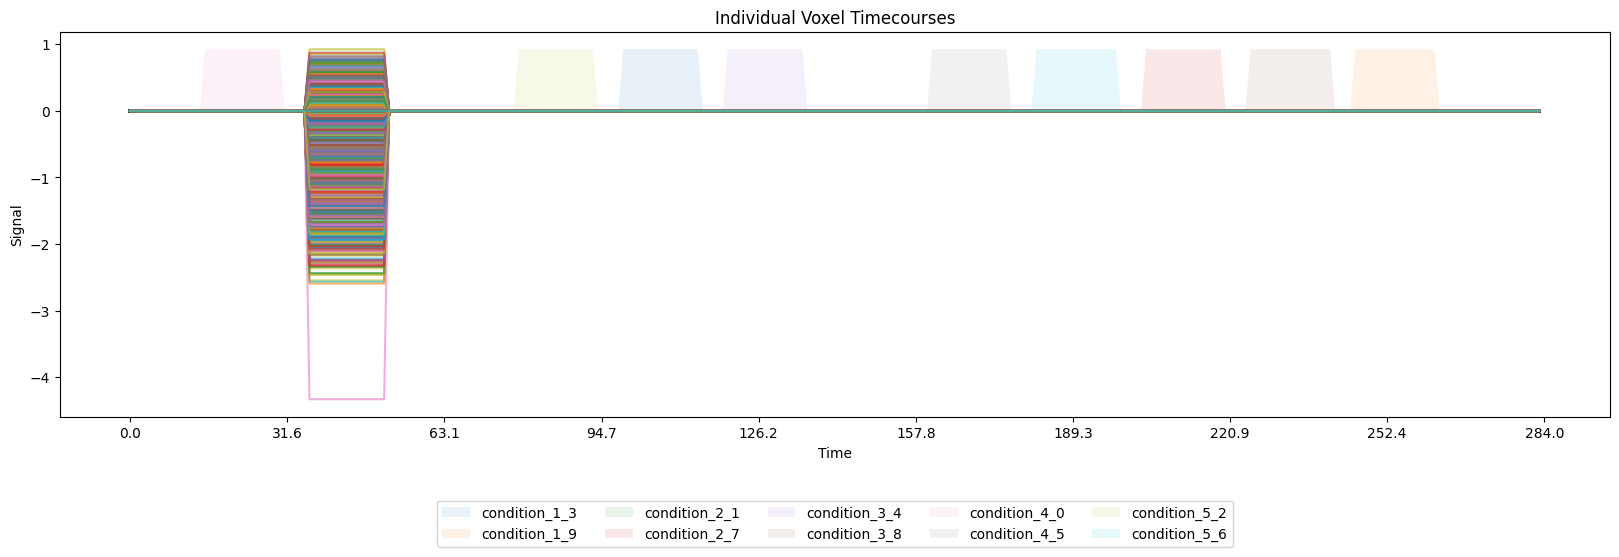

In [150]:
plot_voxel_timecourse(activity_per_condition[0, :, :], bmatrix)

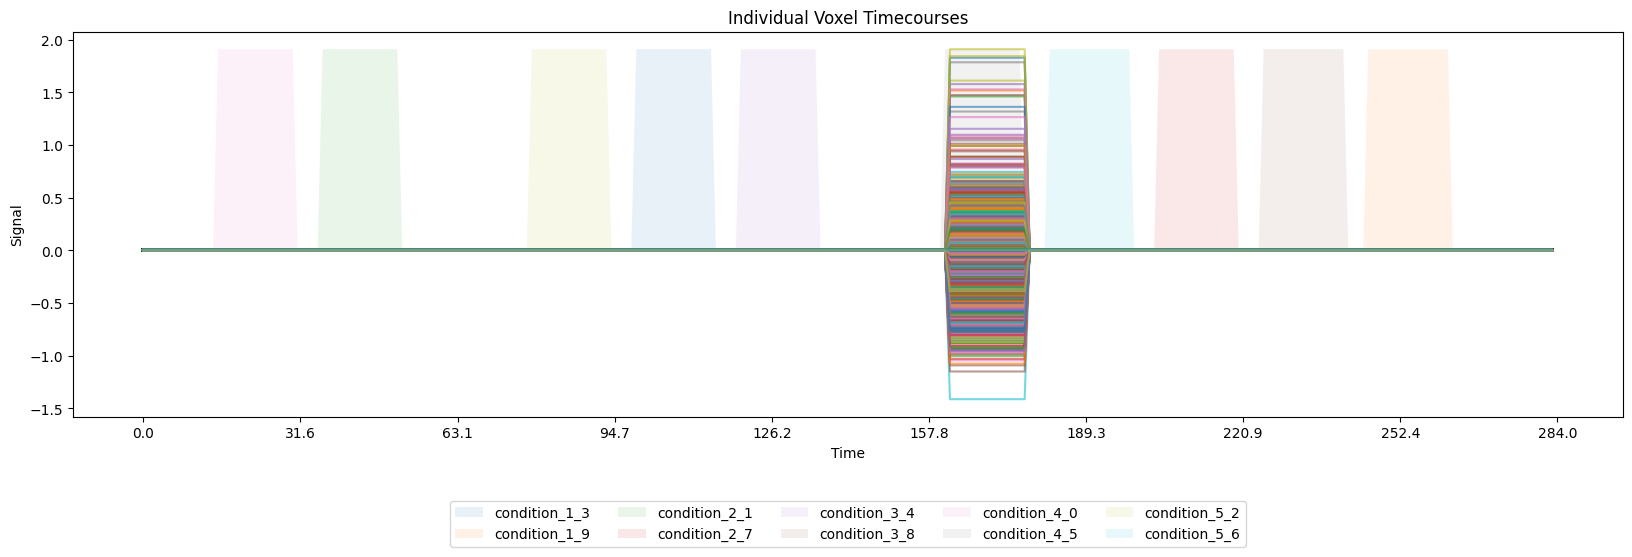

In [139]:
plot_voxel_timecourse(activity_per_condition[1, :, :], bmatrix)

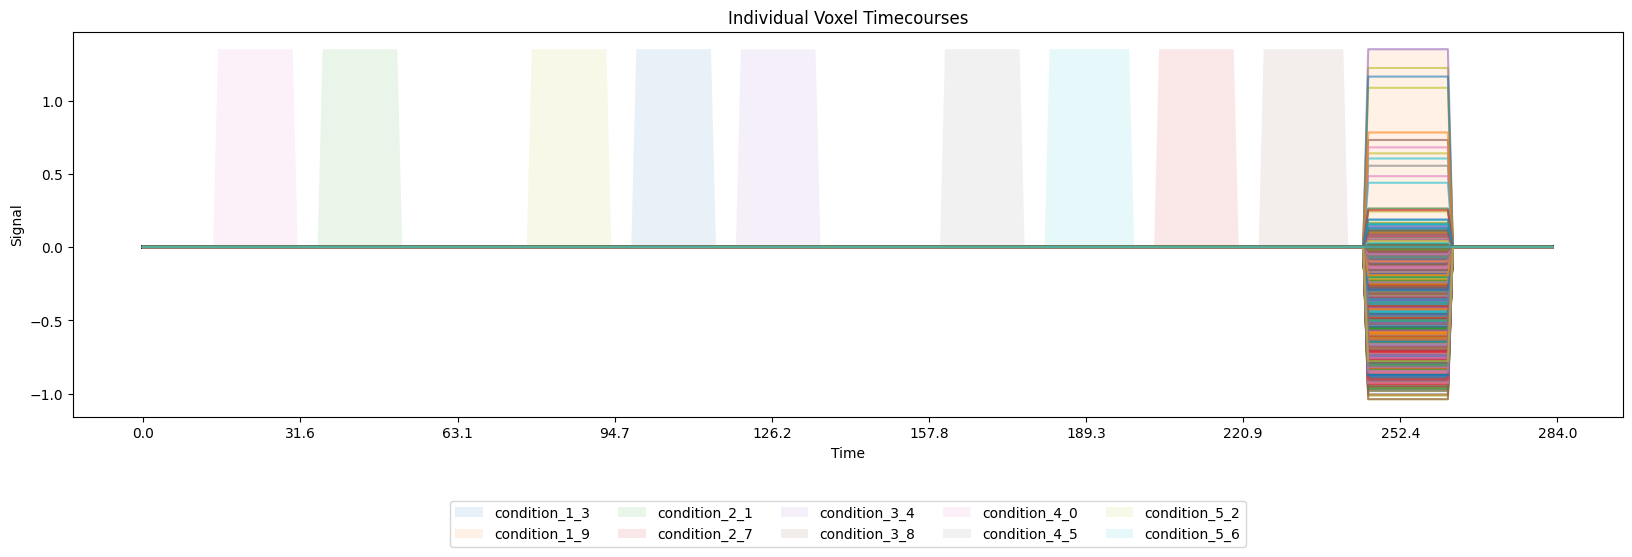

In [141]:
plot_voxel_timecourse(activity_per_condition[3, :, :], bmatrix)

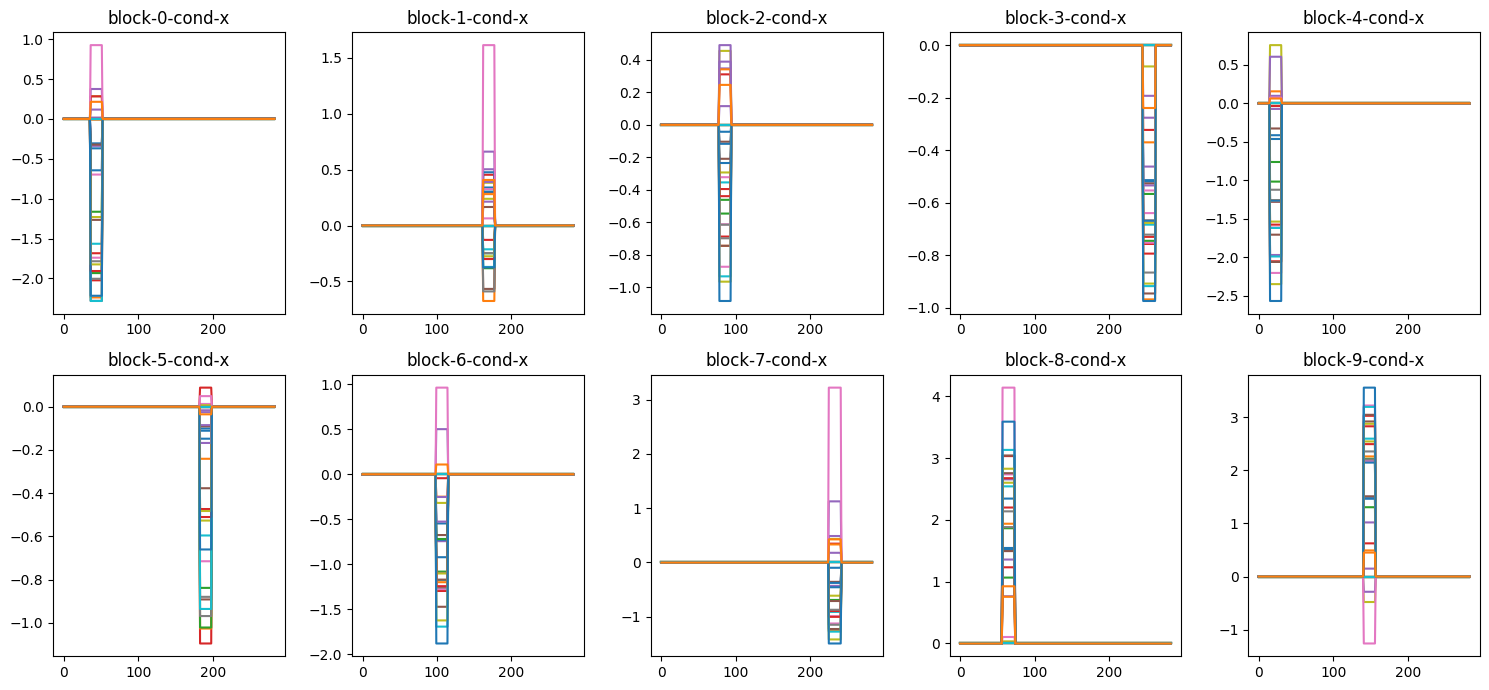

In [165]:
pick = 42
rand_voxel = np.random.choice(np.arange(0, activity_per_condition.shape[2]), pick, replace=False)

arr = bmatrix.to_numpy()
conditions = arr.flatten()[np.r_[True, np.diff(arr.flatten()) != 0]]

plt.figure(figsize=(15, 7))
for c in range(activity_per_condition.shape[0]):
    plt.subplot(2, 5, c+1)
    plt.plot(activity_per_condition[c, rand_voxel, :].T) 
    plt.title(f'block-{c}-cond-x')
plt.tight_layout()

so this one is cool, but completely uselss since it's specific to each condition. ok to predict condition given raw signal, useless for more general stuff